# 🛒 Ürün Fiyat Tahmini 

Bu çalışma, ürünlerin geçmiş fiyat verilerini kullanarak gelecekteki fiyatlarını tahmin etmeyi amaçlamaktadır. Yarışma kapsamında sunulan veri seti; ürün adı, besin değeri, üretim yeri, satıldığı market ve şehir gibi özelliklerle birlikte zaman serisi formatında günlük fiyat bilgisini içermektedir.

## 📁 Veri Seti Açıklaması

Kullanılan veri dosyaları:

- `train.csv`: Eğitim verisi. Her satır, bir ürünün belirli bir tarihteki fiyat bilgilerini içerir.
- `testFeatures.csv`: Test setinin girdileri. Bu verilere dayanarak tahmin yapılacaktır.

Veri setinde kullanılan başlıca sütunlar:

- `tarih`: Ürünün özelliklerinin belirlendiği tarih
- `ürün`: Ürün ismi
- `ürün besin değeri`: Ürünün sahip olduğu besin değeri
- `ürün kategorisi`:  Ürünün ait olduğu kategori
- `ürün fiyatı`: Ürünün fiyatı
- `ürün üretim yeri`: Ürünün üretim yeri
- `market`: Ürünün satıldığı market
- `şehir`: Ürünün satıldığı şehir

Aşağıda veriler yüklenmekte ve temel kontroller yapılmaktadır.




# 📚 Kütüphaneler

In [30]:
# 1. Kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm

In [31]:
# 2. Verileri yükle
train = pd.read_csv("train.csv")
test = pd.read_csv("testFeatures.csv")

In [33]:
# 3. İlk birkaç satırı görüntüle
train.head()

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir
0,2019-01-01,kıyma,120,et,32.70,Yurt içi,K,S
1,2019-01-01,tavuk,103,et,11.04,Yurt içi,K,S
2,2019-01-01,hindi,160,et,11.20,Yurt içi,K,S
3,2019-01-01,Bakla-kuru,354,sebze ve bakliyat,7.04,Yurt içi,K,S
4,2019-01-01,Bakla-taze,72,sebze ve bakliyat,13.28,Yurt içi,K,S


In [69]:
test.head()

,id,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün üretim yeri,market,şehir
0,0,2024-01-01,kıyma,120,et,Yurt içi,K,S
1,1,2024-01-01,tavuk,103,et,Yurt içi,K,S
2,2,2024-01-01,hindi,160,et,Yurt içi,K,S
3,3,2024-01-01,Bakla-kuru,354,sebze ve bakliyat,Yurt içi,K,S
4,4,2024-01-01,Bakla-taze,72,sebze ve bakliyat,Yurt içi,K,S


Tüm bağımsız değişkenlerin isimleri ve veri türleri iki veri setinde de uyumlu.

In [71]:
# 4. Satır ve sütun sayısını al
train.shape

(227520, 8)

In [73]:
test.shape

(45504, 8)

In [75]:
# 5. Temel bilgileri alın
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227520 entries, 0 to 227519
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   tarih              227520 non-null  datetime64[ns]
 1   ürün               227520 non-null  object        
 2   ürün besin değeri  227520 non-null  int64         
 3   ürün kategorisi    227520 non-null  object        
 4   ürün fiyatı        227520 non-null  float64       
 5   ürün üretim yeri   227520 non-null  object        
 6   market             227520 non-null  object        
 7   şehir              227520 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 13.9+ MB


In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45504 entries, 0 to 45503
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 45504 non-null  int64         
 1   tarih              45504 non-null  datetime64[ns]
 2   ürün               45504 non-null  object        
 3   ürün besin değeri  45504 non-null  int64         
 4   ürün kategorisi    45504 non-null  object        
 5   ürün üretim yeri   45504 non-null  object        
 6   market             45504 non-null  object        
 7   şehir              45504 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.8+ MB


Veri setinde hiçbir eksik (null) değer bulunmamaktadır. Her sütun, tüm satırlarda eksiksiz bir şekilde doldurulmuştur.

In [79]:
# 6. Temel tanımlayıcı istatistikler oluşturun
train.describe()

,tarih,ürün besin değeri,ürün fiyatı
count,227520,227520.000000,227520.000000
mean,2021-06-16 06:24:00.000000256,143.113924,17.018837
min,2019-01-01 00:00:00,8.000000,0.740000
25%,2020-03-24 06:00:00,41.000000,7.380000
50%,2021-06-16 00:00:00,83.000000,12.860000
75%,2022-09-08 12:00:00,250.000000,21.630000
max,2023-12-01 00:00:00,402.000000,164.530000
std,NaN,133.218871,14.470524


In [5]:
# 7. Tarihleri datetime formatına çevir
train["tarih"] = pd.to_datetime(train["tarih"])
test["tarih"] = pd.to_datetime(test["tarih"])


 # 📊 EDA

Bu bölümde, verinin genel yapısı incelenerek önemli desenler ve dağılımlar ortaya konulacaktır. Görselleştirmelerle birlikte, veri içindeki eksiklikler ve olası önişlem ihtiyaçları da tespit edilecektir.

In [29]:
# 8. Her üründen kaç tane olduğunu hesaplayın
urun_sayilari = train['ürün'].value_counts()

print(urun_sayilari.head)


<bound method NDFrame.head of ürün
kıyma            2880
salam            2880
Çilek            2880
Armut            2880
tereyağ          2880
                 ... 
Nohut            2880
Mercimek-kuru    2880
Marul            2880
Mantar           2880
ceviz            2880
Name: count, Length: 79, dtype: int64>


Veri setinde bulunan tüm ürünler için gözlem (satır) sayısı eşittir. Bu durum, modelin tüm ürünleri adil bir şekilde öğrenmesini sağlar. Bu eşitlik, segmentasyon (ürün bazlı Prophet modelleri) gibi stratejiler için de ideal bir temel sunar.

In [7]:
# 9. Kategorik Sütun Özetleri
for col in ["ürün", "ürün üretim yeri", "market", "şehir"]:
    print(f"{col} -> Benzersiz değer sayısı:", train[col].nunique())

ürün -> Benzersiz değer sayısı: 79
ürün üretim yeri -> Benzersiz değer sayısı: 2
market -> Benzersiz değer sayısı: 3
şehir -> Benzersiz değer sayısı: 8


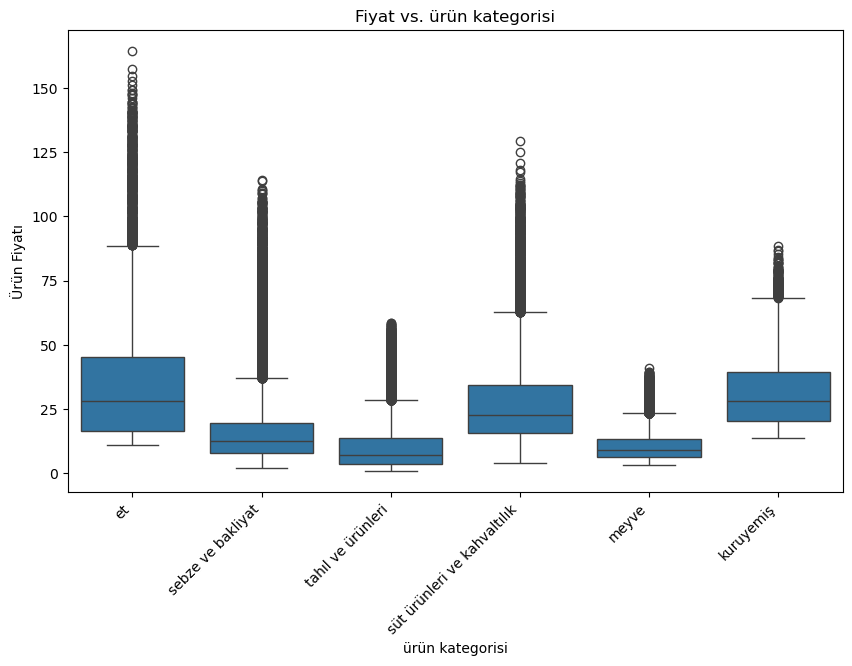

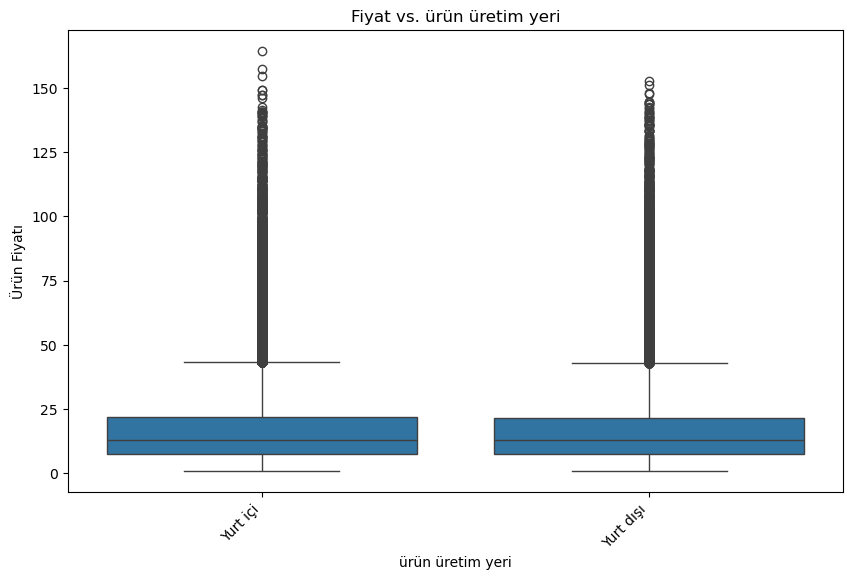

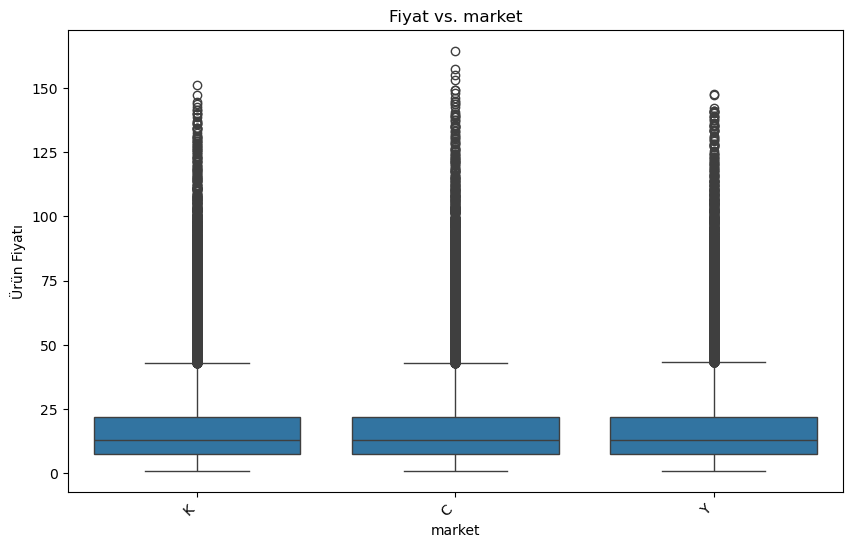

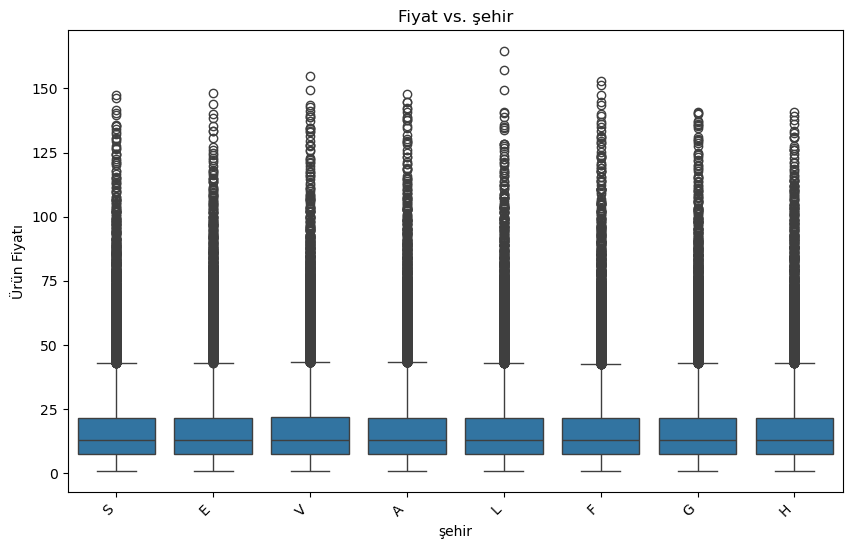

In [17]:
# 10. Kutu Grafikleri (Kategorik Sütunlar)
kategorik_degiskenler = ['ürün kategorisi', 'ürün üretim yeri', 'market', 'şehir']

for degisken in kategorik_degiskenler:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=degisken, y='ürün fiyatı', data=train)
    plt.title(f'Fiyat vs. {degisken}')
    plt.xlabel(degisken)
    plt.ylabel('Ürün Fiyatı')
    plt.xticks(rotation=45, ha='right')
    plt.show()

Boxplot görselleştirmeleri ve gruplama sonrası ortalama değer analizleri, ürün üretim yeri, market ve şehir kategorilerine ait gruplar arasında ürün fiyatlarının benzer dağılımlara sahip olduğunu göstermektedir.

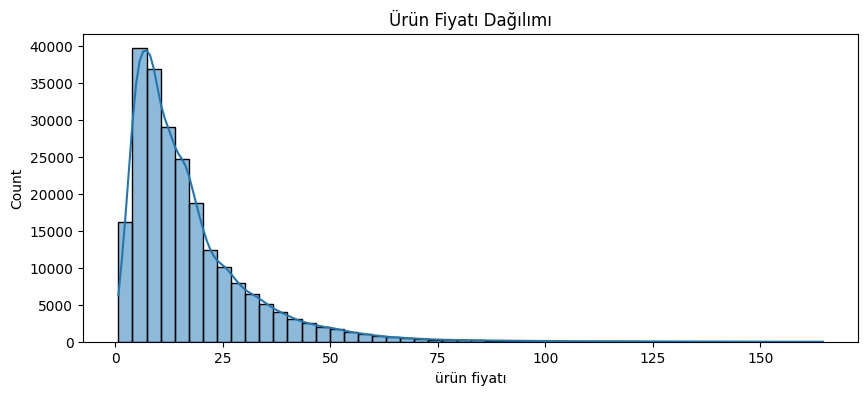

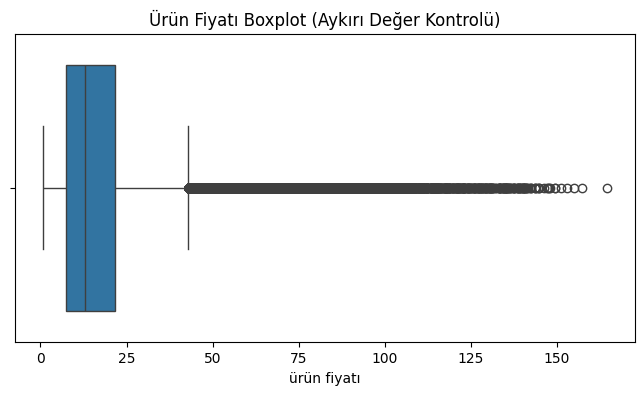

In [9]:
# 11. Hedef Değişken (Ürün Fiyatı) Dağılımı
plt.figure(figsize=(10, 4))
sns.histplot(train["ürün fiyatı"], bins=50, kde=True)
plt.title("Ürün Fiyatı Dağılımı")
plt.show()


plt.figure(figsize=(8, 4))
sns.boxplot(x=train["ürün fiyatı"])
plt.title("Ürün Fiyatı Boxplot (Aykırı Değer Kontrolü)")
plt.show()

Ürün fiyatlarının sağa yatık dağılım göstermesi, daha tutarlı sonuçlar için modelleme sürecinde dönüşüm yapılmasını gerekli kılar.

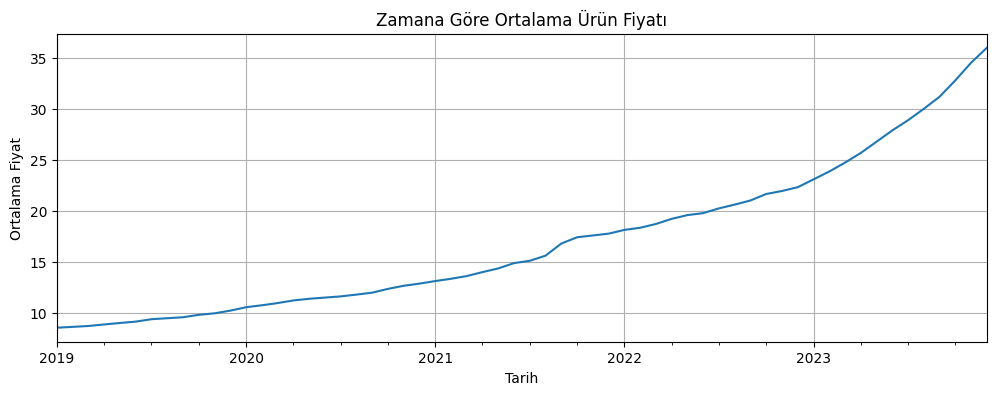

In [10]:
# 12. Zaman Serisi Eğilimi
plt.figure(figsize=(12, 4))
train.groupby("tarih")["ürün fiyatı"].mean().plot()
plt.title("Zamana Göre Ortalama Ürün Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Ortalama Fiyat")
plt.grid(True)
plt.show()

Ortalama fiyat grafiği incelendiğinde, genel olarak yukarı yönlü net bir trend olduğu görülmektedir. Bu trend, dönemsel dalgalanmalardan bağımsız olarak fiyatların uzun vadede artma eğiliminde olduğunu göstermektedir.

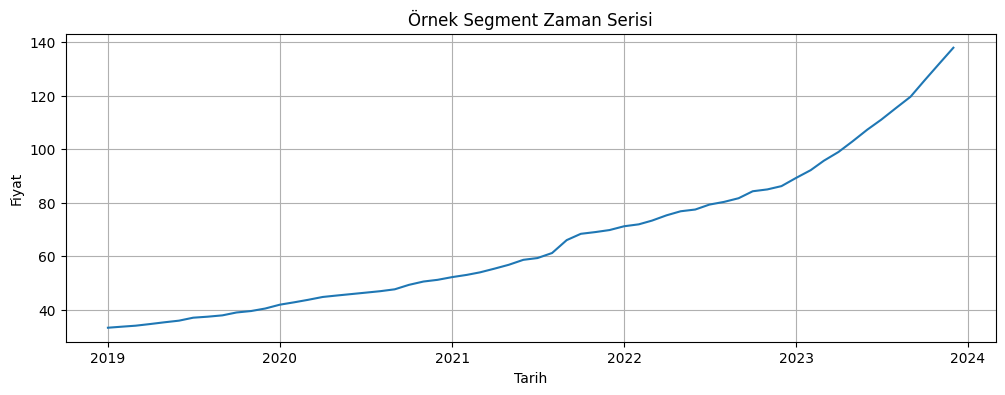

In [11]:
# 13. Örnek Bir Segmentin Zaman Serisi
örnek = train[
    (train["ürün"] == train["ürün"].unique()[0]) &
    (train["market"] == train["market"].unique()[0])
]
örnek_plot = örnek.groupby("tarih")["ürün fiyatı"].mean().reset_index()
plt.figure(figsize=(12, 4))
plt.plot(örnek_plot["tarih"], örnek_plot["ürün fiyatı"])
plt.title("Örnek Segment Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.grid(True)
plt.show()

Modelin daha derinlemesine anlaşılması ve verinin segmentlere göre davranışını incelemek amacıyla, belirli bir ürün ve market kombinasyonuna ait zaman serisi verisi görselleştirilmiştir.

#  🛠️  Özellik Mühendisliği (Feature Engineering)

Modelin başarısını artırmak amacıyla bazı yeni değişkenler türetilmiştir. Prophet modeli, tarihsel bileşenlere dayalı çalıştığı için özellikle tarih sütunundan çıkarılan bilgiler önemlidir.

In [12]:
for df in [train, test]:
    df["gün"] = df["tarih"].dt.day
    df["ay"] = df["tarih"].dt.month
    df["yıl"] = df["tarih"].dt.year
    df["hafta"] = df["tarih"].dt.isocalendar().week.astype(int)
    df["hafta_içi"] = df["tarih"].dt.weekday
    df["hafta_sonu"] = df["hafta_içi"].isin([5, 6]).astype(int)

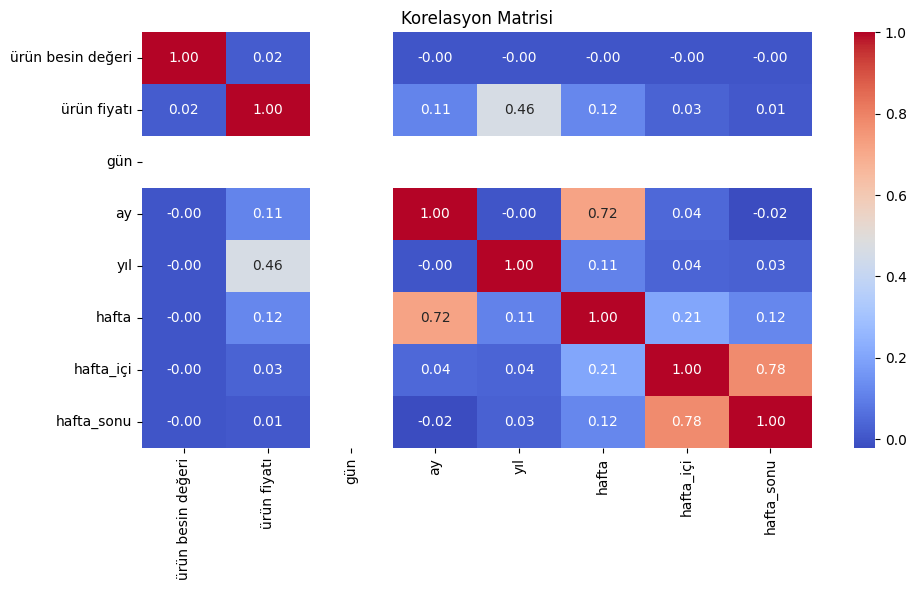


Zayıf korelasyona sahip sütunlar: ['ürün besin değeri', 'hafta_içi', 'hafta_sonu']


In [14]:
#  14. Korelasyon Analizi ve Gereksiz Özellikler
numeric_cols = train.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.tight_layout()
plt.show()

target_corr = corr_matrix["ürün fiyatı"].drop("ürün fiyatı")
low_corr_features = target_corr[abs(target_corr) < 0.05].index.tolist()
print("\nZayıf korelasyona sahip sütunlar:", low_corr_features)

# ⚙️ Model Seçimi

Bu projede zaman serisi verisiyle çalışıldığı için, güçlü sezonsal ve trend bileşenlerini modelleyebilen **Facebook Prophet** algoritması tercih edilmiştir. Prophet, özellikle aşağıdaki nedenlerle seçilmiştir:

- Otomatik mevsimsellik ve trend yakalama yeteneği
- Eksik veri ve dengesiz zaman aralıklarına toleranslı
- Resmi tatillerin etkisini doğrudan modele dahil edebilme
- Yorumlanabilir bileşenler (trend, yıllık mevsimsellik, haftalık mevsimsellik)

In [20]:
# 15. Prophet modellerini saklayacağımız sözlük
prophet_models = {}

In [21]:
# 16. Eğitim segmentlerini belirle
segments = train.groupby(["ürün", "ürün üretim yeri", "market", "şehir", ])


Ürün besin değeri, zayıf korelasyona sahip olduğu için eğitim segmentine eklenmemiştir.

In [24]:
# 17. Her segment için Prophet modelini eğit (log1p dönüşümü ile)
print("Modeller eğitiliyor...")
for segment_key, segment_df in tqdm(segments):
    if len(segment_df) < 10:
        continue  # Veri azsa geç

    prophet_df = segment_df.rename(columns={"tarih": "ds", "ürün fiyatı": "y"})[["ds", "y"]]

    # LOG1P dönüşümü
    prophet_df["y"] = np.log1p(prophet_df["y"])

    try:
        model = Prophet()
        model.fit(prophet_df)
        prophet_models[segment_key] = model
    except:
        continue

Modeller eğitiliyor...


  0%|          | 0/3792 [00:00<?, ?it/s]16:41:47 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/3792 [00:00<38:15,  1.65it/s]16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/3792 [00:00<27:33,  2.29it/s]16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/3792 [00:01<26:11,  2.41it/s]16:41:49 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/3792 [00:01<25:17,  2.50it/s]16:41:49 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 5/3792 [00:02<24:30,  2.58it/s]16:41:49 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 6/3792 [00:02<23:39,  2.6

Fiyat dağılımı çarpık olduğu için log dönüşümü uygulanabilir. Prophet modeli bu dönüşümü desteklemektedir ve çoğu zaman daha iyi sonuç verir.

In [25]:
# 18. Test verileri için tahmin yap
predictions = []

print("Tahminler yapılıyor...")
for idx, row in tqdm(test.iterrows(), total=len(test)):
    segment_key = (row["ürün"], row["ürün üretim yeri"], row["market"], row["şehir"])
    tarih = row["tarih"]

    model = prophet_models.get(segment_key)

    if model:
        future_df = pd.DataFrame({"ds": [tarih]})
        try:
            forecast = model.predict(future_df)

            # EXPm1 ile ters dönüşüm
            predicted_price = np.expm1(forecast["yhat"].values[0])
            predictions.append(predicted_price)
        except:
            predictions.append(None)
    else:
        predictions.append(None)  # Model bulunamazsa boş bırak

Tahminler yapılıyor...


100%|██████████| 45504/45504 [11:45<00:00, 64.53it/s]


Tahminleri tekrar gerçek fiyat düzeyine döndürmek gerekir. Bu yüzden Expm1 (logaritmik dönüşümün tersi) fonksiyonu kullanılmıştır. 

In [26]:
# 19. Tahminleri test veri setine ekle
test = test.reset_index(drop=True)
test["ürün fiyatı"] = predictions

In [27]:
# 20. id'yi test sırasına göre sırala
test["id"] = test.index

In [28]:
# 21. Sadece gerekli sütunları al
submission = test[["id", "ürün fiyatı"]]

In [29]:
# 22. CSV olarak kaydet
submission.to_csv("submission_prophet_v5.csv", index=False)

In [33]:
# 23. Sonucu kontrol et
result = pd.read_csv("submission_prophet_v5.csv")

result.head(10)

,id,ürün fiyatı
0,0,138.025163
1,1,44.792940
2,2,53.594496
3,3,31.640626
4,4,54.806833
5,5,22.296933
6,6,24.566621
7,7,51.526907
8,8,55.502277
9,9,105.580838
